# XGBoost - Extreme Gradient Boost

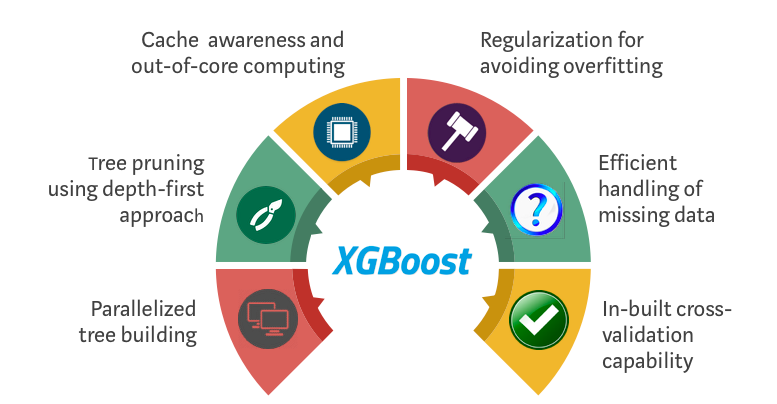

In [55]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

### Step 1 - Data Ingestion

In [2]:
import pandas as pd
df = pd.read_csv("booking_train.csv")
df.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


### Target - booking_status
1. 0 - Booking cancelled
2. 1 - Booking confirmed

### Step 2 - Check basic data quality

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    42100 non-null  int64  
 1   no_of_adults                          42100 non-null  int64  
 2   no_of_children                        42100 non-null  int64  
 3   no_of_weekend_nights                  42100 non-null  int64  
 4   no_of_week_nights                     42100 non-null  int64  
 5   type_of_meal_plan                     42100 non-null  int64  
 6   required_car_parking_space            42100 non-null  int64  
 7   room_type_reserved                    42100 non-null  int64  
 8   lead_time                             42100 non-null  int64  
 9   arrival_year                          42100 non-null  int64  
 10  arrival_month                         42100 non-null  int64  
 11  arrival_date   

In [102]:
df.isna().sum()

id                                      0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [59]:
df.duplicated().sum()

np.int64(0)

### Step 3 - Seperate X and Y(booking_status)
id - statistically insignificant

In [60]:
X = df.drop(columns=["id", "booking_status"])
Y = df[["booking_status"]]

In [61]:
X.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0


In [62]:
Y.head()

,booking_status
0,0
1,0
2,0
3,0
4,1


In [63]:
Y.value_counts()

booking_status
0                 25596
1                 16504
Name: count, dtype: int64

<Axes: xlabel='booking_status'>

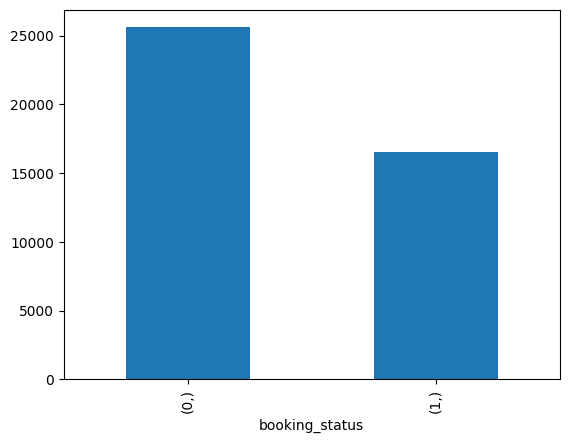

In [64]:
Y.value_counts().plot(kind="bar")

### Step 4 - Apply Preprocessing on X

In [65]:
X.dtypes

no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                         int64
required_car_parking_space                int64
room_type_reserved                        int64
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                       int64
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
dtype: object

In [66]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [67]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
).set_output(transform="pandas")

In [68]:
X_pre = num_pipe.fit_transform(X)
X_pre.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,0.151040,-0.313454,-0.998814,-0.278849,1.294624,-0.160945,-0.515173,-1.170469,0.409661,-2.330398,-0.214091,0.428551,5.766758,33.699120,-0.101479,-0.998052,-0.737691
1,0.151040,-0.313454,0.130259,-0.278849,-0.407020,-0.160945,-0.515173,0.161740,0.409661,-0.209778,1.473487,-1.149928,-0.173408,-0.060506,-0.101479,-0.870153,-0.737691
2,0.151040,-0.313454,-0.998814,-0.979466,-0.407020,-0.160945,-0.515173,2.604122,0.409661,1.557404,-1.564154,-1.149928,-0.173408,-0.060506,-0.101479,-1.415406,-0.737691
3,-1.753925,-0.313454,-0.998814,-0.278849,1.294624,-0.160945,-0.515173,-0.886758,0.409661,1.557404,-1.676659,0.428551,-0.173408,-0.060506,-0.101479,-1.307702,-0.737691
4,0.151040,-0.313454,0.130259,-1.680084,-0.407020,-0.160945,-0.515173,1.901012,0.409661,0.850531,0.010919,-1.149928,-0.173408,-0.060506,-0.101479,-0.122955,-0.737691


### Step 5 - Apply train test split

In [69]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=42)

In [70]:
xtrain.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
15559,0.151040,-0.313454,-0.998814,0.421768,-0.407020,-0.160945,0.685890,-0.479694,0.409661,1.203968,-1.564154,-1.149928,-0.173408,-0.060506,-0.101479,-1.199998,1.842849
32783,0.151040,-0.313454,0.130259,1.122386,-0.407020,-0.160945,0.685890,-0.381012,0.409661,1.557404,1.135971,0.428551,-0.173408,-0.060506,-0.101479,0.189388,0.552579
11797,2.056005,-0.313454,-0.998814,0.421768,-0.407020,-0.160945,0.685890,-0.282330,0.409661,0.497095,-0.889123,0.428551,-0.173408,-0.060506,-0.101479,1.716096,-0.737691
39750,0.151040,-0.313454,-0.998814,-0.979466,2.996268,-0.160945,-0.515173,1.444607,0.409661,0.143658,-0.439102,-1.149928,-0.173408,-0.060506,-0.101479,0.280936,0.552579
28711,0.151040,-0.313454,1.259332,0.421768,-0.407020,-0.160945,0.685890,-0.109636,0.409661,0.850531,-1.001628,0.428551,-0.173408,-0.060506,-0.101479,0.746758,-0.737691


In [71]:
ytrain.head()

,booking_status
15559,0
32783,0
11797,1
39750,1
28711,1


In [72]:
xtest.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
8768,0.15104,-0.313454,-0.998814,0.421768,-0.40702,-0.160945,-0.515173,-0.566041,0.409661,-2.330398,1.135971,-1.149928,-0.173408,-0.060506,-0.101479,-0.643436,0.552579
38340,0.15104,-0.313454,-0.998814,-0.278849,-0.40702,-0.160945,-0.515173,1.481613,0.409661,0.143658,-1.564154,0.428551,-0.173408,-0.060506,-0.101479,-0.285588,-0.737691
7104,0.15104,-0.313454,1.259332,-0.979466,-0.40702,-0.160945,4.289080,-0.553706,0.409661,-1.623525,1.023466,0.428551,-0.173408,-0.060506,-0.101479,0.002252,-0.737691
36898,0.15104,1.908162,1.259332,1.122386,-0.40702,-0.160945,-0.515173,-0.566041,0.409661,1.203968,-0.551607,0.428551,-0.173408,-0.060506,-0.101479,0.541312,3.133119
9747,0.15104,-0.313454,1.259332,0.421768,-0.40702,-0.160945,-0.515173,0.507127,0.409661,-1.270088,1.585992,0.428551,-0.173408,-0.060506,-0.101479,-0.366636,0.552579


In [73]:
ytest.head()

,booking_status
8768,0
38340,1
7104,0
36898,0
9747,0


In [74]:
xtrain.shape

(33680, 17)

In [75]:
xtest.shape

(8420, 17)

### Step 6 - Model Building

##### XGBoost - Hyperparameter tuning not required

In [76]:
import xgboost as xgb

model = xgb.XGBClassifier(max_depth=3, n_estimator=200)

model.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimator=200, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### Step 7 - Model Evaluation

In [77]:
model.score(xtrain, ytrain)

0.8226247030878859

In [78]:
model.score(xtest, ytest)

0.8188836104513064

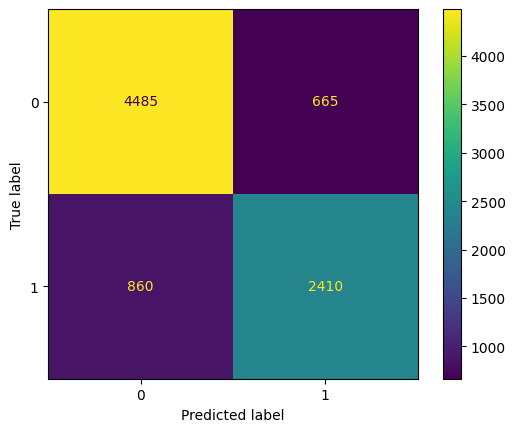

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, xtest, ytest)

In [80]:
ypred_test = model.predict(xtest)
ypred_test[0:5]

array([0, 1, 0, 0, 0])

In [81]:
ytest.head()

,booking_status
8768,0
38340,1
7104,0
36898,0
9747,0


In [82]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      5150
           1       0.78      0.74      0.76      3270

    accuracy                           0.82      8420
   macro avg       0.81      0.80      0.81      8420
weighted avg       0.82      0.82      0.82      8420



In [83]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring="f1_macro")
scores

array([0.80424431, 0.80657783, 0.80243734, 0.80806771, 0.80037413])

In [84]:
scores.mean()

np.float64(0.8043402640349555)

### ROC_AUC (Receiver Operator Characteristics - Area Under Curve)

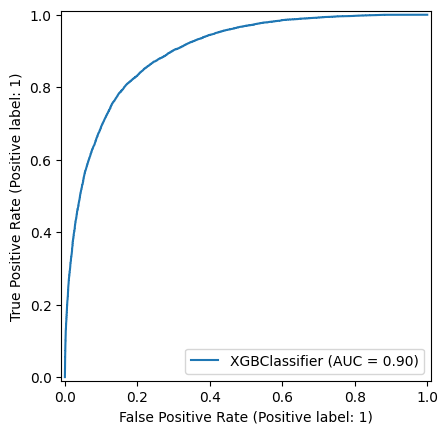

In [85]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, xtrain, ytrain)

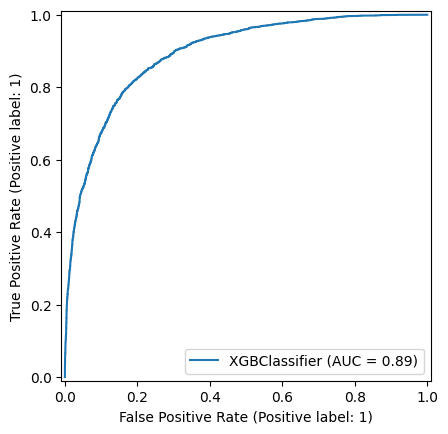

In [86]:
RocCurveDisplay.from_estimator(model, xtest, ytest)

In [87]:
roc_scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring="roc_auc")
roc_scores

array([0.88785739, 0.89125722, 0.88776152, 0.89329975, 0.88773865])

In [88]:
roc_scores.mean()

np.float64(0.8895829075864647)

### Feature importances

In [89]:
model.feature_importances_

array([0.01559582, 0.0050911 , 0.01360551, 0.01435   , 0.0106818 ,
       0.0751768 , 0.02399058, 0.14324604, 0.05255667, 0.04292068,
       0.00801156, 0.21827626, 0.07773899, 0.        , 0.00222134,
       0.06006569, 0.23647113], dtype=float32)

In [90]:
imp = pd.Series(model.feature_importances_, index=xtrain.columns)

In [91]:
imp.sort_values(ascending=False)

no_of_special_requests                  0.236471
market_segment_type                     0.218276
lead_time                               0.143246
repeated_guest                          0.077739
required_car_parking_space              0.075177
avg_price_per_room                      0.060066
arrival_year                            0.052557
arrival_month                           0.042921
room_type_reserved                      0.023991
no_of_adults                            0.015596
no_of_week_nights                       0.014350
no_of_weekend_nights                    0.013606
type_of_meal_plan                       0.010682
arrival_date                            0.008012
no_of_children                          0.005091
no_of_previous_bookings_not_canceled    0.002221
no_of_previous_cancellations            0.000000
dtype: float32

<Axes: >

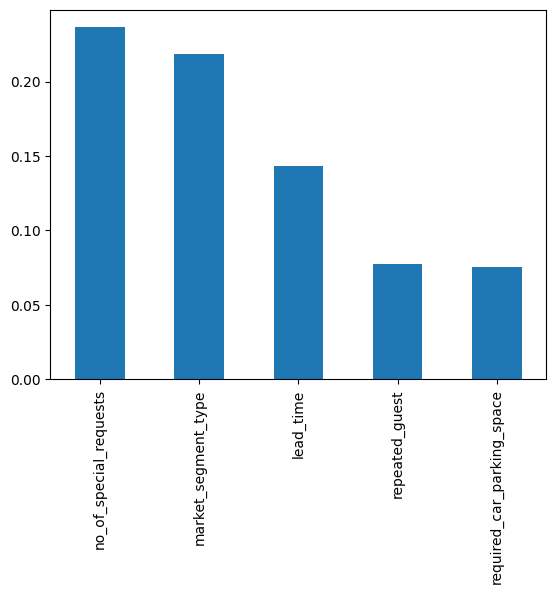

In [92]:
imp.sort_values(ascending=False)[0:5].plot(kind="bar")

### Step 8 - Out of Sample prediction

In [93]:
xnew = pd.read_csv("booking_test.csv")
xnew.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,42100,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2
1,42101,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0
2,42102,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1
3,42103,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0
4,42104,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0


In [94]:
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [95]:
xnew2 = xnew.copy()
xnew2 = xnew2.drop(columns=["id"])

In [96]:
xnew2

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2
1,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0
2,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1
3,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0
4,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,2,0,1,2,0,0,0,315,2018,9,30,1,0,0,0,160.00,0
28064,2,0,2,2,0,0,0,81,2018,3,25,0,0,0,0,65.00,1
28065,2,0,1,2,0,0,0,40,2018,10,22,0,0,0,0,85.00,0
28066,3,0,0,4,0,0,1,4,2018,9,6,1,0,0,0,162.75,0


In [97]:
xnew2_pre = num_pipe.transform(xnew2)
xnew2_pre.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,2.056005,-0.313454,0.130259,1.122386,-0.407020,-0.160945,0.685890,0.087728,0.409661,1.557404,-1.226638,0.428551,-0.173408,-0.060506,-0.101479,0.297092,1.842849
1,0.151040,-0.313454,-0.998814,0.421768,-0.407020,-0.160945,-0.515173,-1.010111,-2.441040,0.850531,0.573445,-1.149928,-0.173408,-0.060506,-0.101479,-0.526846,-0.737691
2,0.151040,4.129777,-0.998814,-0.979466,-0.407020,-0.160945,3.088017,-1.059452,0.409661,0.143658,-0.664112,0.428551,-0.173408,-0.060506,-0.101479,3.646696,0.552579
3,0.151040,-0.313454,-0.998814,0.421768,-0.407020,-0.160945,-0.515173,-0.195983,0.409661,-0.916652,1.585992,-1.149928,-0.173408,-0.060506,-0.101479,-0.641282,-0.737691
4,-1.753925,-0.313454,-0.998814,-0.278849,2.996268,-0.160945,-0.515173,-1.195140,0.409661,0.497095,0.573445,0.428551,-0.173408,-0.060506,-0.101479,1.061793,-0.737691


In [98]:
preds = model.predict(xnew2_pre)
preds[0:5]

array([0, 0, 0, 0, 0])

In [103]:
probs = model.predict_proba(xnew2_pre)[:, 1]
probs[0:5]

array([0.1242318 , 0.0832388 , 0.39197055, 0.07835032, 0.48277658],
      dtype=float32)

In [100]:
res = xnew[["id"]]
res

,id
0,42100
1,42101
2,42102
3,42103
4,42104
...,...
28063,70163
28064,70164
28065,70165
28066,70166


In [104]:
res["status_pred"] = preds
res["prob"] = probs

In [105]:
res = res.round(4)
res

,id,status_pred,prob
0,42100,0,0.1242
1,42101,0,0.0832
2,42102,0,0.3920
3,42103,0,0.0784
4,42104,0,0.4828
...,...,...,...
28063,70163,1,0.9520
28064,70164,0,0.0481
28065,70165,0,0.1313
28066,70166,0,0.4488


In [106]:
res["status_pred"].value_counts()

status_pred
0    17965
1    10103
Name: count, dtype: int64

<Axes: xlabel='status_pred'>

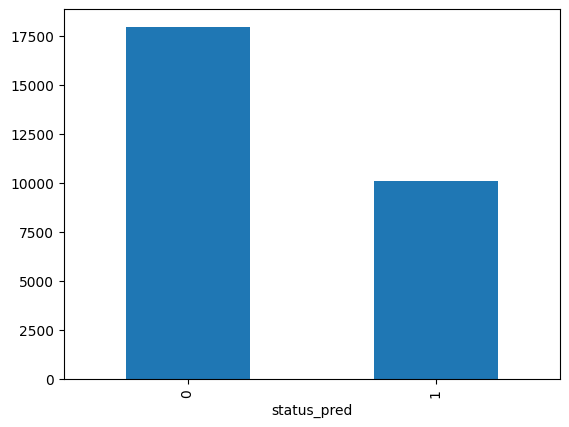

In [107]:
res["status_pred"].value_counts().plot(kind="bar")

In [108]:
res.to_csv("XGBResults.csv", index=False)

### Save the preprocessor and model object

In [109]:
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [110]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimator=200, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [111]:
import joblib

In [112]:
joblib.dump(num_pipe, "pre.joblib")

['pre.joblib']

In [113]:
joblib.dump(model, "booking_xgb.joblib")

['booking_xgb.joblib']

### Load the pre and model

In [114]:
p = joblib.load("pre.joblib")
p

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [115]:
m = joblib.load("booking_xgb.joblib")
m

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimator=200, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

: 